# Link Analysis

# Table of Content

- [Setup](#setup)
- [Algorithm Implementation](#implement)
    - [Hits](#hits)
    - [PageRank](#pagerank)
    - [SimRank](#simrank)
- [Discussion](#discussion)
    - [Result Analysis](#result)
    - [Computation Performance Analysis](#performance)
    - [Find a way to increase hub, authority](#increase-hub-authority)
    - [Find a way to increase pagerank](#increase-pagerank)

---
# <a name='setup'></a> Setup

In [1]:
%matplotlib inline
%load_ext memory_profiler

In [2]:
from collections import namedtuple
from copy import deepcopy
from pprint import PrettyPrinter
from typing import Dict

import numpy as np
import networkx as nx
from networkx.exception import NetworkXError

In [3]:
pp = PrettyPrinter(indent=4)

## Load Data

In [4]:
Edge = namedtuple('Edge', ('source', 'dest'))

In [5]:
def load_graph_gen(filename):
    with open(filename, 'r') as input_file:
        for line in input_file:
            source, dest = line.strip().split(',')
            yield Edge(source, dest)

In [6]:
file_name_template = 'dataset/graph_{num}.txt'

graphs = list()
for i in range(1, 7):
    filename = file_name_template.format(num=i)
    graph_gen = load_graph_gen(filename)
    graphs.append(nx.DiGraph(graph_gen))

In [7]:
def visualize_graphs(graphs, method='plt'):
    def plt_visulize(index, graph):
        plt.figure(index)
        plt.title('graph {index}'.format(index=index))
        nx.draw(graph, arrows=True, with_labels=True)
        
    def pvg_visulize(index, graph):
        A = to_agraph(graph)
        print('graph {index}'.format(index=index))
        display(Image(A.draw(format='png', prog='dot')))
        
    if method == 'plt':
        import matplotlib.pyplot as plt
        
        visulize_method = plt_visulize
    elif method == 'pgv':
        from networkx.drawing.nx_agraph import to_agraph
        import pygraphviz as pgv
        import pydot_ng as pydot
        from IPython.display import Image, display
        
        visulize_method = pvg_visulize
        
    for index, graph in enumerate(graphs, 1):
        visulize_method(index, graph)

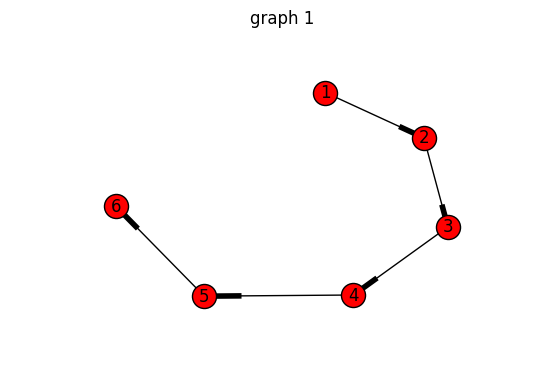

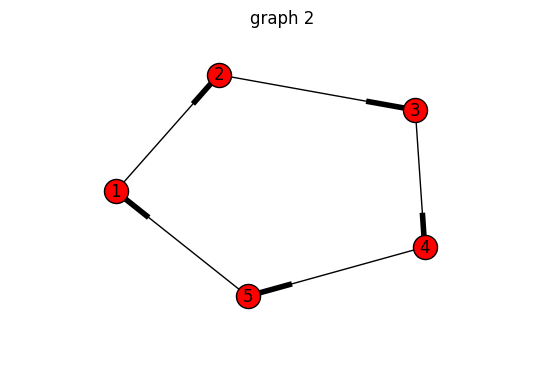

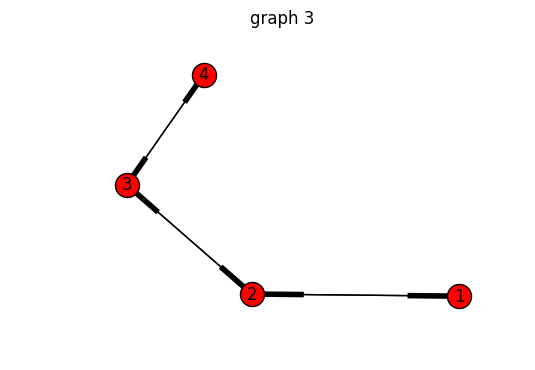

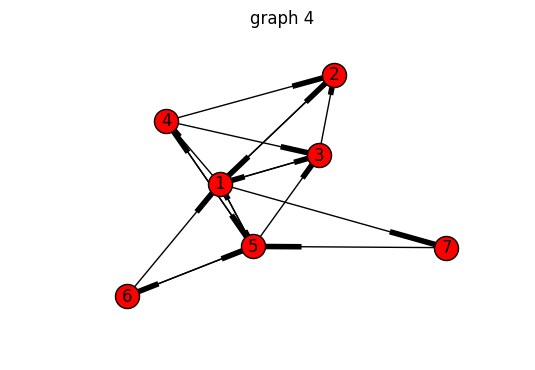

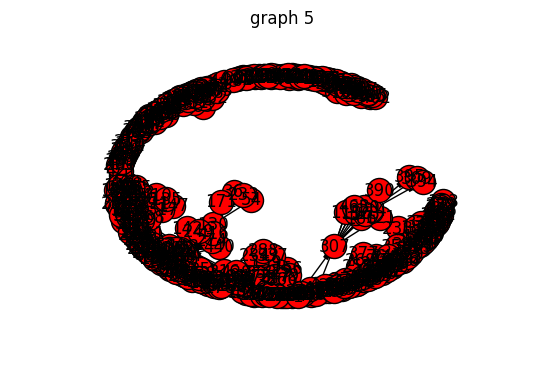

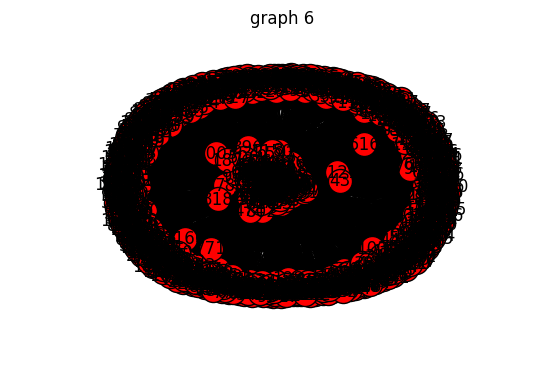

In [8]:
visualize_graphs(graphs)

---

# Algorithm  Implementation

## <a name='hits'></a> Hits

### Self Implement of HITS (1)

In [9]:
def initGraph(G):
    for node in G:
        G.add_node(node, authority=1)
        G.add_node(node, hub=1)
    return G

In [10]:
def normalized(G, h, a):
    totalH, totalA, t = 0, 0, 0
    for node in G:
        totalH += h[node]
        totalA += a[node]
    for node in G:
        #t += abs(h[node] / totalH - G.node[node]['hub'])
        t += abs(a[node] / totalA - G.node[node]['authority'])
        G.node[node]['hub'] = h[node] / totalH
        G.node[node]['authority'] = a[node] / totalA
    return G,t

In [11]:
def authorityHub(G, h, a):
    for node in G:
        h[node], a[node] = 0,0
        for ch in G.successors(node):
            h[node] += G.node[ch]['authority']
        for pa in G.predecessors(node):
            a[node] += G.node[pa]['hub']
    G,t = normalized(G,h,a)
    return G,h,a,t

In [12]:
def HITS(G, max_iter=100, tol=1e-08, nstart=None, normalized=True):
    h, a = {}, {}
    initGraph(G)
    it, t = 0, 1
    while it < max_iter and t > tol:
        G,h,a,t = authorityHub(G,h,a)
        print(it,t)
        it += 1
    for node in G:
        h[node] = G.node[node]['hub']
        a[node] = G.node[node]['authority']        
    return h,a

### Self Implement of HITS (2)

In [13]:
def maximal(m):
    #total = np.sqrt(np.sum(np.square(np.abs(m))))
    maximum = np.max(np.abs(m))
    return m/maximum #total

In [14]:
def normal(m):
    total = np.sum(np.abs(m))
    return m/total

In [15]:
def compare(m1, m2):
    result = np.sum(np.abs(m1-m2))
    return result

In [16]:
def hits(G, max_iter=100, tol=1e-08, nstart=None, normalized=True):
    k = G.number_of_nodes()
    nodeDict, Hub, Auth = {}, {}, {}
    i, it, t = 0, 0, 1
    for node in G:
        nodeDict[node] = i
        i += 1
        
    A = np.zeros((k, k))
    for node in G:    
        for n in G.neighbors(node):
            A[nodeDict[node]][nodeDict[n]] = 1
    A.shape=(k,k)  
    AT = np.transpose(A)
    
    h = np.ones((k,1))/k
    a = np.ones((k,1))/k 
    
    while it <= max_iter and t > tol:
        pre_h = h
        a = maximal(AT.dot(pre_h))
        h = maximal(A.dot(a))
    
        t = compare(h, pre_h)# + compare(a, pre_a)
        it += 1
    
    h = normal(h)
    a = normal(a)
    for key in nodeDict.keys():
        Hub[key] = h[nodeDict[key]][0]
        Auth[key] = a[nodeDict[key]][0]
        
    return Hub, Auth


## <a name='pagerank'></a> Page Rank

In [17]:
def pagerank(graph: nx.classes.digraph.DiGraph,
             *, alpha: float = 0.85, epsilon: float = 1e-06) -> Dict[object, float]:
    """Page Rank
    
    Args:
        graph: Networkx Directed Graph
        alpha: 1 - damping factor
        epsilon: The threshold to teminate iterations
        
    Returns:
        Pageranks of each nodes
    """
    
    node_num = graph.number_of_nodes()
    adj_matrix = np.array(nx.to_numpy_matrix(graph))
    out_degs = np.sum(adj_matrix, axis=1)
    damping_factor = 1 - alpha
    
    # Nodes with no outgoing edges
    dangle_nodes = [
        index
        for index, o_deg in enumerate(graph.out_degree().values())
        if not o_deg
    ]
    
    # Page Ranks
    prs = np.array([1/node_num for _ in range(node_num)])
    # Page Ranks in previous iteration
    pre_prs = np.array([0 for _ in range(node_num)])
    
    delta = np.sum(np.abs(prs - pre_prs))
    while delta > epsilon:
        pre_prs = deepcopy(prs)
        
        # Page Rank values each node can contribute in each edge
        pr_quotas = np.array(
            [pr/deg if deg else 0 for pr, deg in zip(pre_prs, out_degs)]
        )
        dangle_sum = np.sum([pre_prs[dangle_node]/node_num
                             for dangle_node in dangle_nodes])

        prs = (
            damping_factor / node_num +
            alpha *
            (
                adj_matrix.transpose().dot(pr_quotas[:, np.newaxis]) +
                dangle_sum
            )
        ).flatten()
        
        # Normalize
        prs /= np.sum(prs)
        delta = np.sum(np.abs(prs - pre_prs))
        
    # Mapping node name to its page rank
    prs_mappping = {node: pr for node, pr in zip(graph.nodes(), prs)}
    return prs_mappping


This implementations is based on the following formula

$$ PR(p_i) = {\frac{1-d}{N}} + d(\sum_{p_j\ links\ to\ p_i}{\frac{PR(p_j)}{L(p_j)}} + \sum_{p_j\ has\ no\ out-links}{\frac{PR(p_j)}{N}})$$


In each iteration, I first calculate the pagerank values that each node can contribute in each edge.  
e.g. The pagerank of node 1 is 0.5 and node 1 has 2 outgoing edge. The pagerank quota of ode 1 would be 0.5/2 = 0.25

Then, the pagerank values of all dangling nodes (i.e. nodes with no outgoing edges) are divided by numbers of nodes and then summed up as `dangle_sum`.
This would be the $\sum_{p_j\ has\ no\ out-links}{\frac{PR(p_j)}{L(p_j)}})$ part.

After that, I transpose the adjacent matrix of this graph so that the values of each rows would be all the ingoing nodes of certain node.  
Next, I calculate the dot product of this matrix and pagerank quotas.
The result would be the $\sum_{p_j\ links\ to\ p_i}{\frac{PR(p_j)}{N}}$ part.

Add this two part, multiply damping factor, add ${\frac{1-d}{N}}$ and then we will get the pagerank result of this iteration.

Repeat these steps until the difference between pagerank and pagerank in the previous iteration is smaller than epsilon.

### Reference 
[PageRank Lecture Note](http://www.ccs.northeastern.edu/home/daikeshi/notes/PageRank.pdf)

## <a name='simrank'></a> SimRank

In [18]:
np.seterr(divide='ignore', invalid='ignore')

def simrank(graph, *, C=0.8, epsilon=1e-06):
    node_num = graph.number_of_nodes()
    adj_matrix = np.array(nx.to_numpy_matrix(graph))
    adj_matrix /= np.sum(adj_matrix, axis=0)
    adj_matrix = np.nan_to_num(adj_matrix)
    
    pre_sim = np.zeros(node_num)
    sim = np.eye(node_num)
    delta = np.sum(np.abs(sim - pre_sim))
    while delta > epsilon:
        pre_sim = deepcopy(sim)
        sim = C * adj_matrix.transpose().dot(pre_sim).dot(adj_matrix)
        for i in range(node_num):
            sim[i, i] = 1
        delta = np.sum(np.abs(sim - pre_sim))
    return sim

---

# <a name='discussion'></a> Discussion

## <a name='result'></a> Result Analysis and Discussion

### Hits

In [19]:
for index, graph in enumerate(graphs, 1):
    print('\nGraph {}'.format(index))
    pp.pprint(hits(graph, np.inf))


Graph 1
(   {   '1': 0.20000000000000001,
        '2': 0.20000000000000001,
        '3': 0.20000000000000001,
        '4': 0.20000000000000001,
        '5': 0.20000000000000001,
        '6': 0.0},
    {   '1': 0.0,
        '2': 0.20000000000000001,
        '3': 0.20000000000000001,
        '4': 0.20000000000000001,
        '5': 0.20000000000000001,
        '6': 0.20000000000000001})

Graph 2
(   {   '1': 0.20000000000000001,
        '2': 0.20000000000000001,
        '3': 0.20000000000000001,
        '4': 0.20000000000000001,
        '5': 0.20000000000000001},
    {   '1': 0.20000000000000001,
        '2': 0.20000000000000001,
        '3': 0.20000000000000001,
        '4': 0.20000000000000001,
        '5': 0.20000000000000001})

Graph 3
(   {   '1': 0.19098300566477841,
        '2': 0.30901699433522162,
        '3': 0.30901699433522162,
        '4': 0.19098300566477841},
    {   '1': 0.19098300552104899,
        '2': 0.30901699447895098,
        '3': 0.30901699447895098,
        '4': 0

### Page Rank

In [20]:
for index, graph in enumerate(graphs, 1):
    print('\nGraph {}'.format(index))
    pp.pprint(pagerank(graph))


Graph 1
{   '1': 0.060716150359376504,
    '2': 0.1123249278306801,
    '3': 0.15619235710247792,
    '4': 0.1934794507762447,
    '5': 0.22517347758916134,
    '6': 0.25211363634205952}

Graph 2
{   '1': 0.20000000000000001,
    '2': 0.20000000000000001,
    '3': 0.20000000000000001,
    '4': 0.20000000000000001,
    '5': 0.20000000000000001}

Graph 3
{   '1': 0.17543856058862933,
    '2': 0.32456143941137072,
    '3': 0.32456143941137072,
    '4': 0.17543856058862933}

Graph 4
{   '1': 0.2802878551778531,
    '2': 0.15876446265602656,
    '3': 0.13888181220259527,
    '4': 0.10821960072742001,
    '5': 0.18419809708011373,
    '6': 0.060570694570464538,
    '7': 0.069077477585526917}

Graph 5
{   '1': 0.0016197098354741731,
    '10': 0.0019549564893277752,
    '100': 0.0017213633324713001,
    '101': 0.0016765570496009661,
    '102': 0.0016782303680582459,
    '103': 0.0017117568732089006,
    '104': 0.0099790659106452004,
    '105': 0.0026183736234603704,
    '106': 0.0019645136719

### Sim Rank

In [21]:
for index, graph in enumerate(graphs, 1):
    print('\nGraph {}'.format(index))
    pp.pprint(simrank(graph))


Graph 1
array([[ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.]])

Graph 2
array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

Graph 3
array([[ 1.        ,  0.        ,  0.        ,  0.66666655],
       [ 0.        ,  1.        ,  0.66666655,  0.        ],
       [ 0.        ,  0.66666655,  1.        ,  0.        ],
       [ 0.66666655,  0.        ,  0.        ,  1.        ]])

Graph 4
array([[ 1.        ,  0.53506349,  0.53506349,  0.36974703,  0.3426946 ,
         0.44956621,  0.35373453],
       [ 0.53506349,  1.        ,  0.27012699,  0.2854419 ,  0.27314849,
         0.44809422,  0.41507678],
       [ 0.53506349,  0.27012699,  1.        ,  0.45405216,  0.4122407 ,
         0.4510382 ,  0.

## <a name='performance'></a> Computation Performance Analysis

### Time

- Hits

In [22]:
%%time

for graph in graphs:
    hits(graph, np.inf)

CPU times: user 432 ms, sys: 23.4 ms, total: 456 ms
Wall time: 311 ms


In [23]:
%%time

for graph in graphs:
    nx.hits(graph, np.inf)

CPU times: user 1.91 s, sys: 37.4 ms, total: 1.95 s
Wall time: 2.03 s


- Page Rank

I compare my implementation of pagerank with a well known library - networkx and found that my implementation is faster.  
By digging into source code, I found one possible reason is that networkx's implementation is more flexible.  
(e.g. It considers the weight of each edge)  
Another reason might be that networks's implementation uses `dict` to store values which is much slower than using `numpy` which is used in my implementation.

In [24]:
%%time

for graph in graphs:
    pagerank(graph)

CPU times: user 68 ms, sys: 12.8 ms, total: 80.7 ms
Wall time: 69.9 ms


In [25]:
%%time

for graph in graphs:
    nx.pagerank(graph, alpha=0.85)

CPU times: user 94 ms, sys: 3.9 ms, total: 97.9 ms
Wall time: 101 ms


- SimRank

In [26]:
%%time

for graph in graphs:
    simrank(graph)

CPU times: user 51.9 s, sys: 1.99 s, total: 53.9 s
Wall time: 21 s


### Memory

- Hits

In [27]:
%%memit

for graph in graphs:
    hits(graph, np.inf)

peak memory: 125.21 MiB, increment: 11.55 MiB


In [28]:
%%memit

for graph in graphs:
    nx.hits(graph, np.inf)

peak memory: 125.02 MiB, increment: 0.05 MiB


- Page Rank

The peak memory of both implementaion is close.

In [29]:
%%memit

for graph in graphs:
    pagerank(graph)

peak memory: 137.70 MiB, increment: 12.69 MiB


In [30]:
%%memit

for graph in graphs:
    nx.pagerank(graph, alpha=0.85)

peak memory: 138.10 MiB, increment: 0.64 MiB


- SimRank

In [31]:
%%memit

for graph in graphs:
    simrank(graph)

peak memory: 177.29 MiB, increment: 39.19 MiB


## <a name='increase-hub-authority'></a> Find a way to increase hub, authority

## <a name='increase-pagerank'></a> Find a way to increase pagerank

### Graph 1

In [32]:
g1 = deepcopy(graphs[0])

In [33]:
g1_original_pagerank = pagerank(g1)
g1_original_pagerank

{'1': 0.060716150359376504,
 '2': 0.1123249278306801,
 '3': 0.15619235710247792,
 '4': 0.1934794507762447,
 '5': 0.22517347758916134,
 '6': 0.25211363634205952}

- Add an edge from node 1 to another

In [34]:
for dest in ['3', '4', '5', '6']:
    g1.add_edge('1', dest)
    print("Page Rank after adding edge 1 -> {dest}:".format(dest=dest), pagerank(g1)['1'])
    g1.remove_edge('1', dest)

Page Rank after adding edge 1 -> 3: 0.0615451114639
Page Rank after adding edge 1 -> 4: 0.0625498732763
Page Rank after adding edge 1 -> 5: 0.0637747942557
Page Rank after adding edge 1 -> 6: 0.0652786918357


As the result shows, by adding edge (1, 3) and (1, 6) can increase pagerank of node 1.

### Graph 2

In [35]:
g2 = deepcopy(graphs[1])

In [36]:
g2_origin_pagerank = pagerank(g2)
g2_origin_pagerank

{'1': 0.20000000000000001,
 '2': 0.20000000000000001,
 '3': 0.20000000000000001,
 '4': 0.20000000000000001,
 '5': 0.20000000000000001}

- Add an edge from node 1 to another

In [37]:
for dest in ['3', '4', '5', '6']:
    g2.add_edge('1', dest)
    print("Page Rank after adding edge 1 -> {dest}:".format(dest=dest), pagerank(g2)['1'])
    g2.remove_edge('1', dest)

Page Rank after adding edge 1 -> 3: 0.215140813314
Page Rank after adding edge 1 -> 4: 0.236176152488
Page Rank after adding edge 1 -> 5: 0.266873610439
Page Rank after adding edge 1 -> 6: 0.208528534572


As the result shows, by adding an edge from node 1 to any other node increases pagerank of node 1.

### Graph 3

In [38]:
g3 = deepcopy(graphs[2])

In [39]:
g3_origin_pagerank = pagerank(g3)
g3_origin_pagerank

{'1': 0.17543856058862933,
 '2': 0.32456143941137072,
 '3': 0.32456143941137072,
 '4': 0.17543856058862933}

- Add an edge from node 1 to another

In [40]:
for dest in ['3', '4']:
    g3.add_edge('1', dest)
    print("Page Rank after adding edge 1 -> {dest}:".format(dest=dest), pagerank(g3)['1'])
    g3.remove_edge('1', dest)

Page Rank after adding edge 1 -> 3: 0.149973195546
Page Rank after adding edge 1 -> 4: 0.14375


Adding node from node 1 to any other node cannot increase pagerank of node 1.

- Remove an edge from node 1 while not making it become isolated

In [41]:
g3.remove_edge('1', '2')
print("Page Rank after removing edge 1 -> 2: ", pagerank(g3)['1'])
g3.add_edge('1', '2')

Page Rank after removing edge 1 -> 2:  0.171884504545


As we can see, by removeing edge (1, 2) increases pagerank of node 1.